In [1]:
from datasets import load_dataset, load_from_disk
import random
from LatentPixel import TGraph
from LatentPixel import LatentLlama, BIN_FONT
import re
import pandas as pd
from tqdm import tqdm
import logging
import torch
loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    logger.setLevel(logging.WARNING)

/home/tai/data/miniconda3/envs/pixel/lib/python3.10/site-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(


In [87]:
data[292]['text']

'Juan Gálvez (Buenos Aires, 14 February 1916 – 3 March 1963 in Olavarría) was an Argentine racing driver, and the brother of driver Oscar Alfredo Gálvez. They started racing together in Turismo Carretera but then took separate ways and competed in different cars. He made his debut in the Avellaneda Automobile Club 1000-Mile race on 14 February 1941 and finished second to Juan Manuel Fangio. His first win came on 22 February 1949 at the I Vuelta de Santa Fe. He won the Turismo Carretera championship nine times, in 1949, 1950, 1951, 1952, 1955, 1956, 1957, 1958 and 1961. His last victory was at the IV Vuelta de Laboulaye (1962) behind the wheel of a Ford. He was killed during an accident at Olavarría race in 1963. In 13 years of motorsport he competed in 153 races, winning more than 50 times. See also\n\nAutódromo Juan y Oscar Gálvez\n\nRacing drivers from Buenos Aires\n1916 births\n1963 deaths\nRacing drivers killed while racing\nArgentine racing drivers\nTurismo Carretera drivers\nSpor

In [2]:
def randomSplit(sent: str) -> tuple[str, str, str]:
    words = sent.split()
    if len(words) == 0:
        return '', '', ''
    bint = min(50, len(words))
    eint = min(120, len(words))
    idx = random.randint(bint, eint) - 1
    sent1 = ' '.join(words[:idx])
    sent2 = ' '.join(words[idx:])
    return sent1, sent2, words[idx]

pat = re.compile('([a-zA-Z]+)')
def add_word(words: str | list[str], corpus: set[str]):
    global pat
    if isinstance(words, str):
        words = re.findall(pat, words)

    for word in words:
        corpus.add(str(word).lower())
    return

def evaluate_babi(generated: list, vocab: set) -> dict[str, float]:
    pat = re.compile('^([a-zA-Z]*)')
    correct_paddle = 0
    correct_tess = 0
    corrects = 0
    n_readable = 0
    readables = []
    cor_samples = []
    for idx in tqdm(range(len(generated))):
        cor = False
        readable = False
        pro = generated[idx][0]
        t: str = generated[idx][1]
        t = t.replace('g', 'q')
        g = generated[idx][2]
        img: TGraph = g[pro._num_text_patches[0]-1:g._num_text_patches[0]-1]
        text = img.ocr(method='paddleocr', square=False, span=True, span_ratio=1.3, scale=3)
        raw = text[0].lower().split()
        if len(raw) == 0:
            raw = ''
        else:
            raw = raw[0]
        m = pat.match(text[0])
        if m is not None:
            text = m.groups()[0]
        else:
            text = ''
        if raw in vocab:
            readable = True
        text = text.replace('g', 'q')
        if text == t:
            correct_paddle += 1
            cor = True
        text = img.ocr(method='tesseract', square=False, span=True, span_ratio=1.3, scale=3)
        raw = text[0].lower().split()
        if len(raw) == 0:
            raw = ''
        else:
            raw = raw[0]  
        m = pat.match(text[0])
        if m is not None:
            text = m.groups()[0]
        else:
            text = ''
        if raw in vocab:
            readable = True
        text = text.replace('g', 'q')
        if text == t:
            correct_tess += 1
            cor = True
        if cor:
            corrects += 1
            cor_samples.append(idx)
        if readable:
            n_readable += 1
            readables.append(idx)
    return {
        'paddleocr': correct_paddle / len(generated),
        'tesseract': correct_tess / len(generated),
        'union': corrects / len(generated),
        'readability': n_readable / len(generated),
        'readables': readables,
        'correct_samples': cor_samples
    }



## Init model and render

In [10]:
'''
Yintao's devbox environment
'''
_ =TGraph.init_render(
    dpi=80,
    font_file=BIN_FONT,
    font_size=8,
    pixels_per_patch=8,
    rgb=False,
    binary=True,
    max_seq_length=800,
    patch_len=2
)
model = LatentLlama(
    backbone_path='storage/llama_2_backbone/',
    num_channels=1,
    patch_len=2,
    patch_size=8,
    binary=True
)

Coder path is none, do not load compressor for this model


Some weights of LlamaForPatchCausalInference were not initialized from the model checkpoint at storage/llama_2_backbone/ and are newly initialized: ['embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
model = LatentLlama(
    backbone_path='storage/checkpoints/1MModels/dllama_2_b/backbone',
    num_channels=1,
    patch_len=2,
    patch_size=8,
    binary=True
)

Coder path is none, do not load compressor for this model


Some weights of LlamaForPatchCausalInference were not initialized from the model checkpoint at storage/checkpoints/1MModels/dllama_2_b/backbone and are newly initialized: ['embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Load the pretraining dataset

In [4]:
data = load_from_disk('storage/booksAndWiki2/data/')

In [5]:
samples = []
for i in range(500):
    prompt, _, target = randomSplit(data[i]['text'])
    samples.append((prompt, target))

In [6]:
samples[0]

('While the variance at FVIII:C = 0.09 IU/ml is similar between both methods (CV = 7-8%), better precision is found at FVIII:C = 0.01 IU/ml in the investigated method (CV = 5-8% versus 14% in the reference method). At higher concentrations of the other clotting factors, firm clots are formed within uniform clotting times; given the higher response of the calibration curve, uniformity is further enhanced upon converting APTTs to FVIII:Cs. The method comparison reveals that compositional similarity between calibrators and low FVIII:C samples is crucial at lower dilutions, hence falsely elevated FVIII:Cs are found when using calibration standards',
 'based')

## Generate vocabulary

In [7]:
corpo = pd.read_csv('storage/unigram_freq.csv')
vocab = set()
add_word(corpo.word.tolist()[:10000], vocab)

In [8]:
len(vocab)

10000

## Run model to generate

In [12]:
model.eval()
model.cuda()
generated = []
with torch.no_grad():
    for prompt, target in tqdm(samples):
        prompt = TGraph.from_text([prompt])
        prompt = prompt._spacing_text(3)
        prompt.set_device('cuda')
        gen = model.autoregressive_generate(prompt, None, 4, binary_method='gray_scale', temperature=1.0)
        prompt.set_device('cpu')
        gen.set_device('cpu')
        generated.append((prompt, target, gen))

100%|██████████| 500/500 [00:21<00:00, 23.56it/s]


In [13]:
model.eval()
model.cuda()
generated2 = []
with torch.no_grad():
    for prompt, target in tqdm(samples):
        prompt = TGraph.from_text([prompt])
        prompt = prompt._spacing_text(3)
        prompt.set_device('cuda')
        gen = model.autoregressive_generate(prompt, None, 4, binary_method='gray_scale', temperature=0.1)
        prompt.set_device('cpu')
        gen.set_device('cpu')
        generated2.append((prompt, target, gen))

100%|██████████| 500/500 [00:19<00:00, 25.52it/s]


In [21]:
model.eval()
model.cuda()
generated1 = []
with torch.no_grad():
    for prompt, target in tqdm(samples):
        prompt = TGraph.from_text([prompt])
        prompt = prompt._spacing_text(3)
        prompt.set_device('cuda')
        gen = model.autoregressive_generate(prompt, None, 4, binary_method='gray_scale', temperature=0.3)
        prompt.set_device('cpu')
        gen.set_device('cpu')
        generated1.append((prompt, target, gen))

100%|██████████| 500/500 [00:19<00:00, 25.34it/s]


In [14]:
model.eval()
model.cuda()
generated3 = []
with torch.no_grad():
    for prompt, target in tqdm(samples):
        prompt = TGraph.from_text([prompt])
        prompt = prompt._spacing_text(3)
        prompt.set_device('cuda')
        gen = model.autoregressive_generate(prompt, None, 4, binary_method='gray_scale', temperature=10.0)
        prompt.set_device('cpu')
        gen.set_device('cpu')
        generated3.append((prompt, target, gen))

100%|██████████| 500/500 [00:19<00:00, 25.42it/s]


## Save Image Samples

In [32]:
for idx, (p, t, g) in enumerate(generated):
    p: TGraph
    g: TGraph
    folder = f'pretrain_samples/{idx}_target_{t}'
    p.to_file(f'{folder}/prompt')
    g.to_file(f'{folder}/gen_thresholding_0_5')

In [39]:
for idx, (p, t, g) in enumerate(generated):
    p: TGraph
    g: TGraph
    folder = f'pretrain_samples/{idx}_target_{t}'
    g.to_file(f'{folder}/gen_gray_temp_1_0', binary_method='gray_scale')

In [36]:
for idx, (p, t, g) in enumerate(generated1):
    p: TGraph
    g: TGraph
    folder = f'pretrain_samples/{idx}_target_{t}'
    g.to_file(f'{folder}/gen_gray_temp_0_3', binary_method='gray_scale')

In [37]:
for idx, (p, t, g) in enumerate(generated2):
    p: TGraph
    g: TGraph
    folder = f'pretrain_samples/{idx}_target_{t}'
    g.to_file(f'{folder}/gen_gray_temp_0_1', binary_method='gray_scale')

In [38]:
for idx, (p, t, g) in enumerate(generated3):
    p: TGraph
    g: TGraph
    folder = f'pretrain_samples/{idx}_target_{t}'
    g.to_file(f'{folder}/gen_gray_temp_10_0', binary_method='gray_scale')

## Plot the statistics of generated patches

In [53]:
dists = {}

In [71]:
values = []
for p, t, g in generated:
    patch = g[p._num_text_patches[0]-1:p._num_text_patches[0]]
    patch: TGraph
    values.append(patch._value.flatten())
values = torch.concat(values).flatten().numpy()
dists['temp=1.0'] = values

values = []
for p, t, g in generated1:
    patch = g[p._num_text_patches[0]-1:p._num_text_patches[0]]
    patch: TGraph
    values.append(patch._value.flatten())
values = torch.concat(values).flatten().numpy()
dists['temp=0.3'] = values


values = []
for p, t, g in generated2:
    patch = g[p._num_text_patches[0]-1:p._num_text_patches[0]]
    patch: TGraph
    values.append(patch._value.flatten())
values = torch.concat(values).flatten().numpy()
dists['temp=0.1'] = values


values = []
for p, t, g in generated3:
    patch = g[p._num_text_patches[0]-1:p._num_text_patches[0]]
    patch: TGraph
    values.append(patch._value.flatten())
values = torch.concat(values).flatten().numpy()
dists['temp=10.0'] = values

values = []
for p, t, g in generated:
    patch = g[p._num_text_patches[0]-1:p._num_text_patches[0]]
    patch.binary()
    patch: TGraph
    values.append(patch._value.flatten())
values = torch.concat(values).flatten().numpy()
dists['binary th=0.5'] = values

values = []
for p, t, g in generated3:
    patch = p[10:11]
    patch: TGraph
    values.append(patch._value.flatten())
values = torch.concat(values).flatten().numpy()
dists['gold'] = values



In [72]:
len(values)

64000

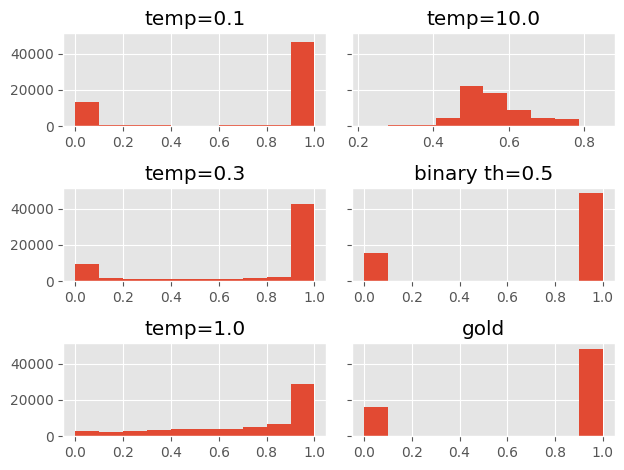

In [84]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig, axs = plt.subplots(3, 2, sharey=True, tight_layout=True)
n_bins = 10

# We can set the number of bins with the *bins* keyword argument.
axs[0][0].hist(dists['temp=0.1'], bins=n_bins)
axs[0][0].title.set_text('temp=0.1')

axs[1][0].hist(dists['temp=0.3'], bins=n_bins)
axs[1][0].title.set_text('temp=0.3')

axs[2][0].hist(dists['temp=1.0'], bins=n_bins)
axs[2][0].title.set_text('temp=1.0')

axs[0][1].hist(dists['temp=10.0'], bins=n_bins)
axs[0][1].title.set_text('temp=10.0')

axs[1][1].hist(dists['binary th=0.5'], bins=n_bins)
axs[1][1].title.set_text('binary th=0.5')

axs[2][1].hist(dists['gold'], bins=n_bins)
axs[2][1].title.set_text('gold')

plt.show()

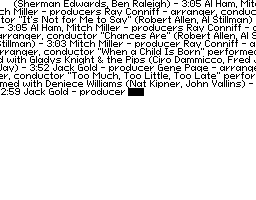

In [81]:
p.to_PIL()[0]

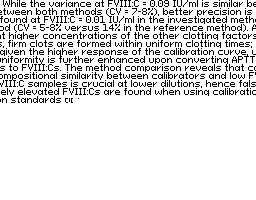

In [45]:
g.to_PIL()[0]

## Evaluate Readability

### 1. Results of 0.1M Checkpoint

In [10]:
result = evaluate_babi(generated, vocab)
print(result)

100%|██████████| 1000/1000 [03:58<00:00,  4.19it/s]

{'paddleocr': 0.103, 'tesseract': 0.117, 'union': 0.131, 'readability': 0.366, 'readables': [1, 5, 16, 22, 23, 24, 29, 31, 32, 36, 37, 39, 42, 43, 45, 46, 47, 58, 59, 65, 68, 69, 71, 72, 74, 78, 79, 81, 84, 87, 89, 93, 96, 99, 102, 106, 108, 113, 116, 120, 121, 125, 127, 128, 130, 132, 135, 137, 141, 145, 147, 148, 149, 151, 152, 153, 156, 160, 161, 164, 167, 168, 169, 172, 173, 175, 176, 178, 185, 188, 191, 193, 196, 198, 199, 200, 203, 204, 205, 206, 209, 214, 215, 218, 219, 222, 223, 228, 230, 231, 232, 234, 235, 236, 239, 242, 244, 247, 251, 252, 253, 256, 260, 261, 266, 267, 268, 275, 278, 280, 281, 283, 286, 290, 292, 294, 295, 300, 302, 306, 307, 309, 310, 311, 313, 314, 316, 318, 319, 323, 328, 332, 334, 339, 340, 344, 348, 349, 352, 353, 354, 358, 360, 361, 362, 372, 376, 379, 380, 382, 383, 384, 385, 388, 389, 390, 396, 398, 399, 400, 412, 413, 414, 416, 417, 419, 423, 424, 426, 427, 431, 438, 439, 444, 448, 451, 453, 454, 456, 458, 462, 464, 471, 479, 481, 484, 487, 488, 494

### 2. Results of 1M Checkpoint

In [14]:
result = evaluate_babi(generated, vocab)
print(result)

100%|██████████| 1000/1000 [03:59<00:00,  4.18it/s]

{'paddleocr': 0.158, 'tesseract': 0.168, 'union': 0.181, 'readability': 0.397, 'readables': [0, 4, 5, 8, 9, 12, 16, 19, 22, 23, 26, 29, 31, 33, 34, 43, 45, 48, 50, 52, 54, 57, 58, 59, 60, 61, 63, 65, 68, 69, 71, 72, 74, 76, 79, 81, 84, 93, 94, 95, 100, 108, 112, 113, 116, 122, 127, 128, 132, 134, 135, 136, 137, 138, 147, 149, 151, 152, 157, 160, 161, 164, 168, 169, 173, 175, 176, 178, 181, 182, 185, 186, 188, 190, 191, 194, 195, 196, 197, 202, 204, 208, 209, 210, 214, 215, 216, 219, 222, 229, 231, 233, 234, 235, 236, 243, 247, 251, 252, 256, 257, 260, 261, 266, 267, 269, 271, 273, 274, 276, 277, 278, 280, 282, 285, 286, 291, 293, 297, 298, 299, 301, 302, 304, 310, 311, 313, 314, 315, 316, 318, 319, 320, 322, 323, 325, 326, 328, 330, 331, 334, 339, 340, 343, 344, 345, 346, 349, 350, 352, 353, 355, 358, 359, 360, 363, 369, 372, 375, 379, 382, 387, 388, 389, 390, 394, 396, 397, 399, 403, 407, 410, 412, 413, 415, 416, 420, 422, 423, 424, 426, 427, 428, 431, 433, 434, 438, 439, 440, 441, 44

### 3. Resultsof 1M checkpoint with 0.1 temperature

In [ ]:
### 4. Results of 1M checkpoint with 10 temperature

School


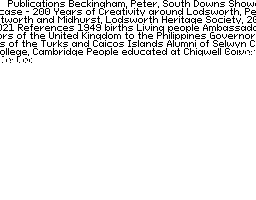

In [119]:
idx = 22
print(generated[idx][1])
generated[idx][2].to_PIL()[0]

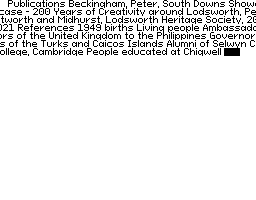

In [120]:
generated[idx][0].to_PIL()[0]

In [125]:
pro = generated[idx][0]
t: str = generated[idx][1]
t = t.replace('g', 'q')
g = generated[idx][2]
img: TGraph = g[pro._num_text_patches[0]-1:g._num_text_patches[0]-1]
text = img.ocr(method='paddleocr', square=False, span=True, span_ratio=1.3, scale=3)

In [126]:
text

['Co']

In [127]:
'co' in vocab

True

In [15]:
len(generated)

1000

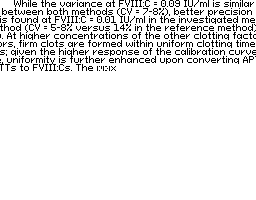

In [20]:
generated[0][2].to_PIL(binary_method='gray_scale')[0]

In [18]:
g.to

tensor([[[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]]]], device='cuda:0')